<a href="https://colab.research.google.com/github/basakozsoy/SDXL_DreamBooth_LoRA/blob/main/Maya_SDXL_DreamBooth_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Initialization**: Import necessary libraries & files

In [ ]:
# Check the GPU
!nvidia-smi

Mon May 13 23:55:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              51W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

Make sure to install `diffusers` from `main`.

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-05-13 23:55:42--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84307 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.01s   

2024-05-13 23:55:43 (5.98 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84307/84307]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset**: Preview & modify the dataset

Preview the images:

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

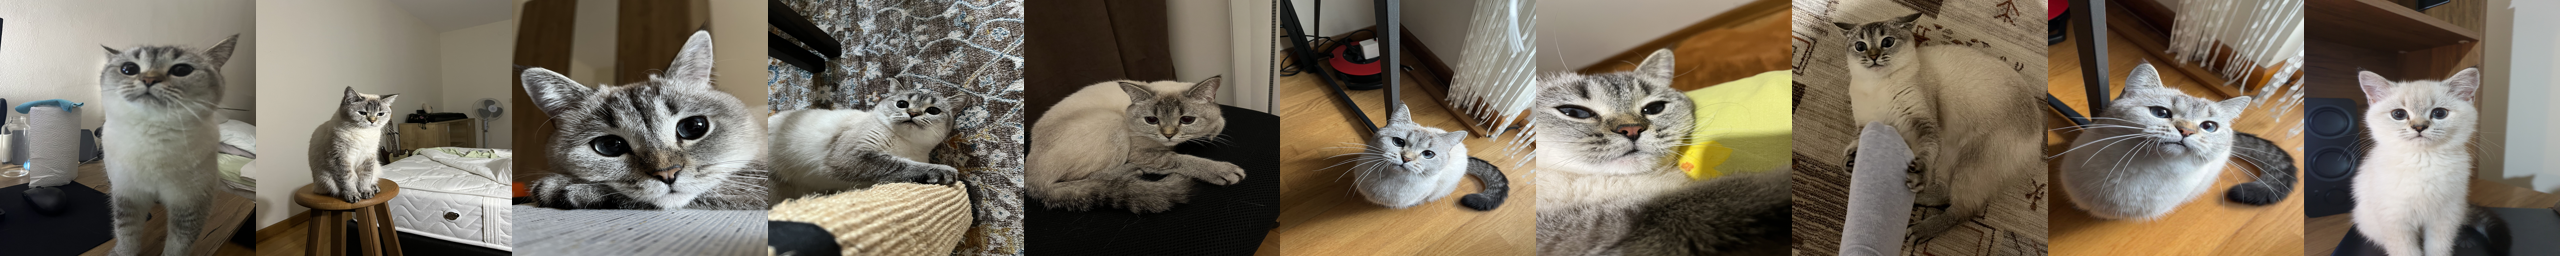

In [ ]:
import glob

# change path to display images from your local dir
img_paths = "/content/drive/MyDrive/images/maya/converted/data/train/*.png"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 10
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### If needed, generate custom captions with BLIP
Load BLIP to auto caption your images:

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
#local_dir = "./dog/"
img_paths = "/content/drive/MyDrive/images/maya/converted/train/"

imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{img_paths}*.png")]
print(imgs_and_paths)

[('/content/drive/MyDrive/images/maya/converted/train/IMG_6630.png', <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3024x4032 at 0x789C464A7130>), ('/content/drive/MyDrive/images/maya/converted/train/IMG_5743.png', <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3024x4032 at 0x789C464A63B0>), ('/content/drive/MyDrive/images/maya/converted/train/IMG_5557.png', <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3024x4032 at 0x789C3D4ABDC0>), ('/content/drive/MyDrive/images/maya/converted/train/IMG_2516.png', <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3024x4032 at 0x789C3D4AB820>), ('/content/drive/MyDrive/images/maya/converted/train/IMG_7384.png', <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3024x4032 at 0x789D638B6E00>), ('/content/drive/MyDrive/images/maya/converted/train/IMG_3723.png', <PIL.PngImagePlugin.PngImageFile image mode=RGB size=3024x4032 at 0x789D638B6E30>), ('/content/drive/MyDrive/images/maya/converted/train/IMG_7263.png', <PIL.PngImagePlugin

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK"

we can use "a photo of TOK cat" / "a photo of TOK maya cat"

In [ ]:
import json

local_dir = '/content/drive/MyDrive/images/maya/converted/'
caption_prefix = "a photo of TOK cat, "
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":f'train/{img[0].split("/")[-1]}', "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free some memory:

In [ ]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

Initialize `accelerate`:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Training

#### Set Hyperparameters
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training


To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [ ]:
!pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="/content/drive/MyDrive/images/maya/converted/data" \
  --output_dir="maya_LoRA" \
  --image_column="image" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of TOK cat" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2024-05-14 00:01:24.667785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 00:01:24.667830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 00:01:24.669466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 00:01:25.812389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/14/2024 00:01:26 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1

### Save model card function:

In [ ]:
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card

def save_model_card(
    repo_id: str,
    use_dora: bool,
    images=None,
    base_model: str = None,
    train_text_encoder=False,
    instance_prompt=None,
    validation_prompt=None,
    repo_folder=None,
    vae_path=None,
):
    widget_dict = []
    if images is not None:
        for i, image in enumerate(images):
            image.save(os.path.join(repo_folder, f"image_{i}.png"))
            widget_dict.append(
                {"text": validation_prompt if validation_prompt else " ", "output": {"url": f"image_{i}.png"}}
            )

    model_description = f"""
# {'SDXL' if 'playground' not in base_model else 'Playground'} LoRA DreamBooth - {repo_id}

<Gallery />

## Model description

These are {repo_id} LoRA adaption weights for {base_model}.

The weights were trained  using [DreamBooth](https://dreambooth.github.io/).

LoRA for the text encoder was enabled: {train_text_encoder}.

Special VAE used for training: {vae_path}.

## Trigger words

You should use {instance_prompt} to trigger the image generation.

## Download model

Weights for this model are available in Safetensors format.

[Download]({repo_id}/tree/main) them in the Files & versions tab.

"""
    if "playground" in base_model:
        model_description += """\n
## License

Please adhere to the licensing terms as described [here](https://huggingface.co/playgroundai/playground-v2.5-1024px-aesthetic/blob/main/LICENSE.md).
"""
    model_card = load_or_create_model_card(
        repo_id_or_path=repo_id,
        from_training=True,
        license="openrail++" if "playground" not in base_model else "playground-v2dot5-community",
        base_model=base_model,
        prompt=instance_prompt,
        model_description=model_description,
        widget=widget_dict,
    )
    tags = [
        "text-to-image",
        "text-to-image",
        "diffusers-training",
        "diffusers",
        "lora" if not use_dora else "dora",
        "template:sd-lora",
    ]
    if "playground" in base_model:
        tags.extend(["playground", "playground-diffusers"])
    else:
        tags.extend(["stable-diffusion-xl", "stable-diffusion-xl-diffusers"])

    model_card = populate_model_card(model_card, tags=tags)
    model_card.save(os.path.join(repo_folder, "README.md"))


# Save model to huggingface:

In [ ]:
from huggingface_hub import whoami
from pathlib import Path

#make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "maya_LoRA"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [ ]:
# Run this cell with your training arguments to make sure your model is uploaded
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of TOK cat",
    validation_prompt=None,
    repo_folder=output_dir,
    use_dora=True,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

README.md:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/basakozsoy/maya_LoRA/commit/80b74fdbaa5f719fa777ff852c82b6e5db391bad', commit_message='End of training', commit_description='', oid='80b74fdbaa5f719fa777ff852c82b6e5db391bad', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/basakozsoy/maya_LoRA

## Inference

In [ ]:
from diffusers import AutoencoderKL
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

In [ ]:
from transformers import PretrainedModel

pretrained_model = PretrainedModel.from_pretrained("madebyollin/sdxl-vae-fp16-fix")
vae = AutoencoderKL(config, vae=pretrained_model, torch_dtype=torch.float16)

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL
from transformers import PretrainedModel

pretrained_model = PretrainedModel.from_pretrained("madebyollin/sdxl-vae-fp16-fix")
vae = AutoencoderKL(config, vae=pretrained_model, torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

In [ ]:
prompt = "a photo of TOK cat in a bucket at the beach"
image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image